In [1]:
import sconce
print(f"Notebook run using pytorch-sconce {sconce.__version__}")

Notebook run using pytorch-sconce 1.2.4


In [2]:
from sconce.data_feeds import SingleClassImageFeed
from sconce.datasets import Subset
from torchvision import datasets, transforms

import numpy as np

## Creating the Training and Validation Data Feeds

In [3]:
split_factor = 0.85
root = 'data/characters'
image_size = 125

training_transform = transforms.Compose([
    transforms.Resize(int(image_size*1.15)),
    transforms.RandomAffine(degrees=(0,10), translate=(0.02, 0.02), scale=(1.0, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

validation_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

base_feed = SingleClassImageFeed.from_image_folder(root=root, transform=training_transform)
training_feed, validation_feed = base_feed.split(split_factor,
        batch_size=60, num_workers=7, shuffle=True, validation_transform=validation_transform)

In [4]:
inputs, targets = training_feed.next()
inputs.shape, targets.shape

(torch.Size([60, 3, 125, 125]), torch.Size([60]))

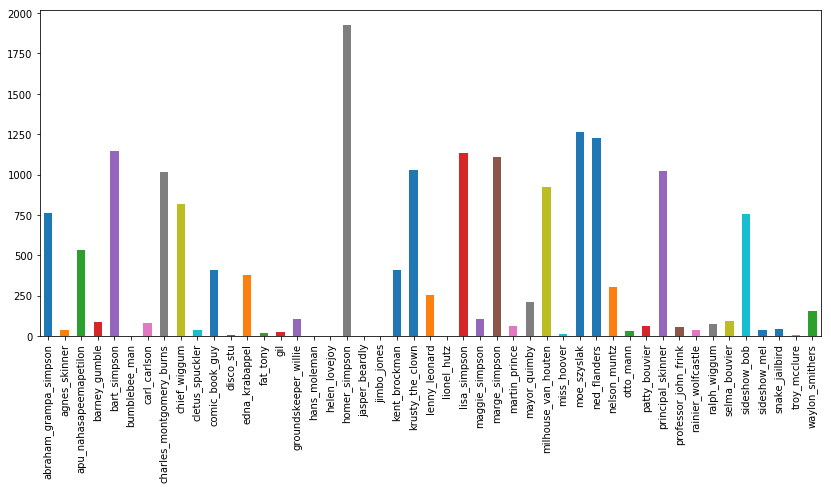

In [5]:
training_feed.plot_class_summary(figsize=(14,6))

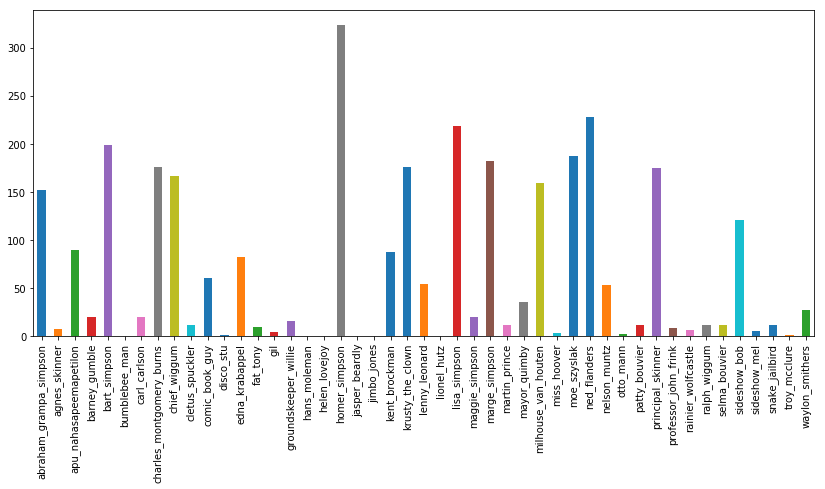

In [6]:
validation_feed.plot_class_summary(figsize=(14,6))

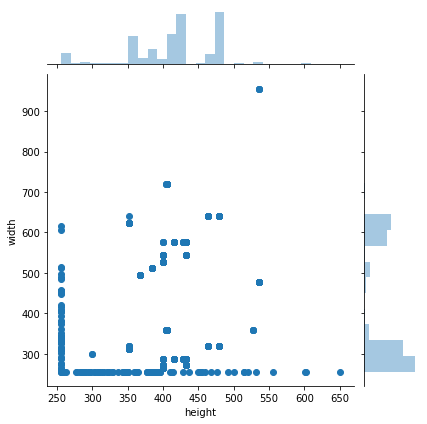

In [7]:
validation_feed.plot_image_size_summary();

In [5]:
from sconce.models import WideResnetImageClassifier

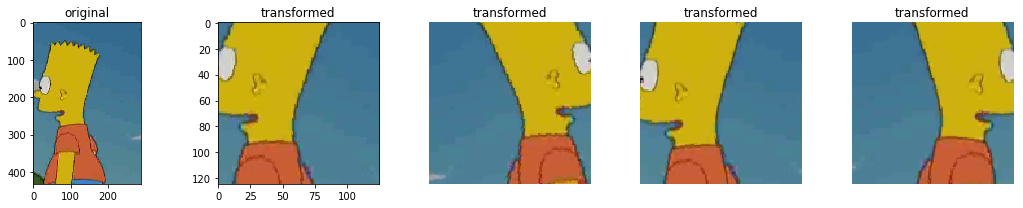

In [37]:
training_feed.plot_transforms(123)

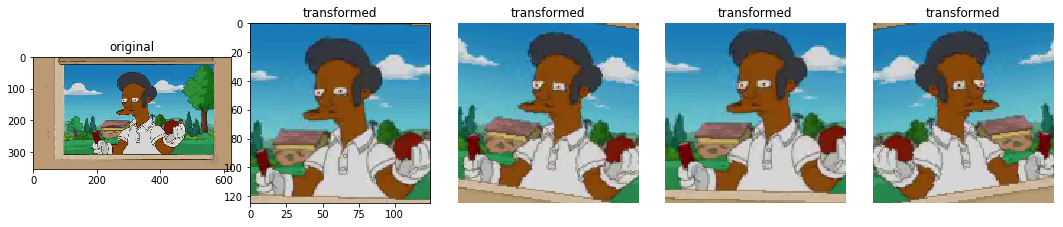

In [38]:
validation_feed.plot_transforms(234)

## Define the Model and construct the Trainer

In [6]:
num_classes = len(training_feed.dataset.classes)
m = WideResnetImageClassifier(image_channels=3, depth=28, widening_factor=2, num_categories=num_classes)

In [7]:
from torch import optim

m.set_optimizer(optim.SGD, lr=0.1, momentum=0.9, weight_decay=5e-4)

In [8]:
import torch

if torch.cuda.is_available:
    m.cuda()
    training_feed.cuda()
    validation_feed.cuda()

In [9]:
from sconce.trainers import SingleClassImageClassifierTrainer

In [10]:
t = SingleClassImageClassifierTrainer(model=m, training_feed=training_feed, validation_feed=validation_feed)

## Survey the learning rate

119/119 [==============================] - 39s 324ms/step - loss: 3.2306


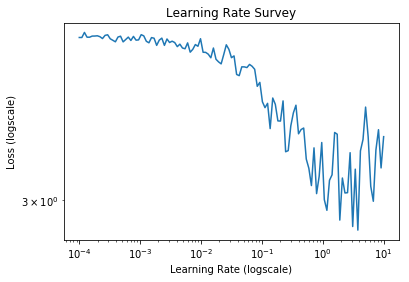

In [13]:
monitor = t.survey_learning_rate(num_epochs=0.4, min_learning_rate=1e-4, max_learning_rate=10)
monitor.dataframe_monitor.plot_learning_rate_survey()

## Train

In [14]:
from sconce.schedules import Triangle
m.set_schedule('learning_rate', Triangle(initial_value=1e-3, peak_value=1e0, peak_fraction=0.33))
m.set_schedule('momentum', Triangle(initial_value=0.98, peak_value=0.02, peak_fraction=0.33))
t.train(num_epochs=20)

5931/5931 [==============================] - 2034s 343ms/step - loss: 0.3925 - val_loss: 0.3881


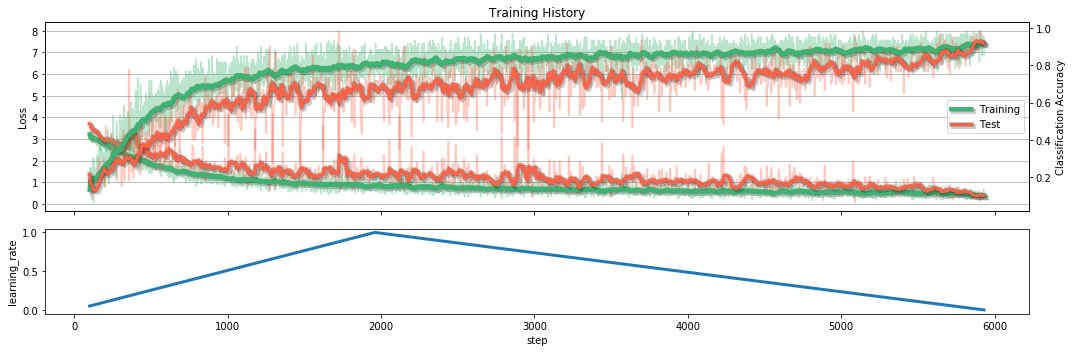

In [16]:
t.monitor.dataframe_monitor.plot(metrics=['loss', 'classification_accuracy']);

## Explore predictions of trained model

In [17]:
t.get_classification_accuracy()

0.9159235668789809

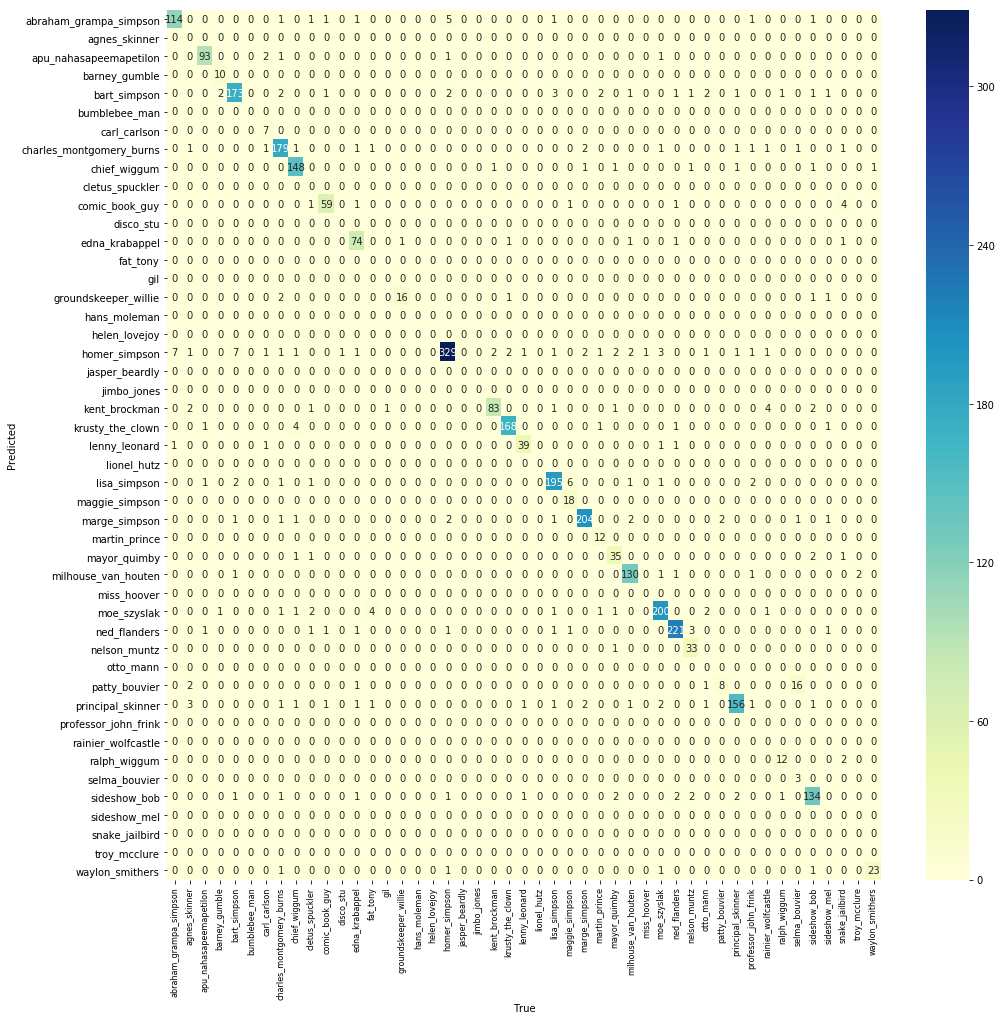

In [24]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 16)) 
ax = t.plot_confusion_matrix(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)
ax

Showing only the first 7 of 168 images


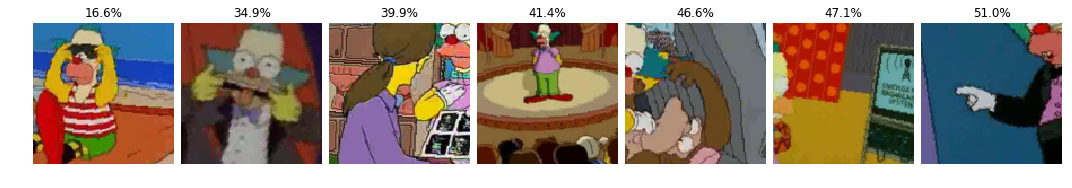

In [33]:
t.plot_samples(predicted_class='krusty_the_clown', true_class='krusty_the_clown');

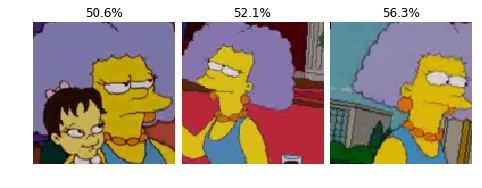

In [32]:
t.plot_samples(predicted_class='selma_bouvier', true_class='selma_bouvier');

Showing only the first 7 of 16 images


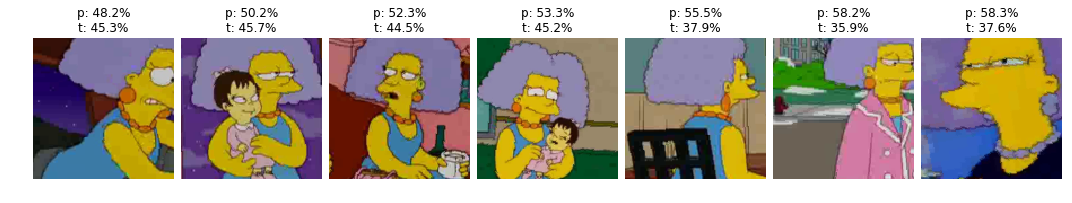

In [29]:
t.plot_samples(predicted_class='patty_bouvier', true_class='selma_bouvier');